# Goal of Experiment

The goal of my experiment is to run a dynamic test of the decided joint material of polyethelyene sheet. From this experiment we hope to fit the data for the damping and stiffness constant. 


# Process and Procedure

__Process__

In order to isolate the joint properties, I manufactured a 2 link, 5-layer laminate structure with 0.002" polyester film as the flexible layer and 6 layer cardstock as the rigid material. I then conducted a dynamic test by constraining one of the links vertically between two plates and pulled unconstrained link to the side, released and let it come to rest. I recorded this experiment with my phone so that I could import the data into tracker, track the position of the blue dot at the end of my segment, and record the position data over time. This data was then imported into python so that I could fit the data to a simulated experiment.

The assumptions I made for this experiment is that the system is exactly vertical. Since I am in a configuration that is meant to negate gravity, but if there was any warping or if the links were not exactly vertical, some forces due to gravity would have an effect. Additionally, I am treating the rigid segments as rigid bodies have no flexure for my model.


__Pictures of Experimental Setup__

<div>
<img src="Damping_test_1.jpg" style="align:left;width:50%;height:50%;" />
</div>

Set up of experiment from above. One link is constrained allowing only one segment to move.

<div>
<img src="Damping_test_2.jpg" style="align:left;width:50%;height:50%;" />
</div>

Side profile of experimental set up. A small blue ball was added to the end of the link to track the motion of the segment as it oscilatted.

__Video__

<video src="Damping_test.MOV" controls="controls" width="560" height="315" align="center">
</video>

Video of experiment that was used for tracker.

# Model Fitting

The model I used to fit for this experiment was a single link that had a torsional spring and damping force applied to the point of rotation. The reason that the model was built like this is because only one link in the experiment had free motion and the cause of motion was the felxure joint.

The optimization method used for my assignment was the scipy.optimize.minimze function. The reason that this method was used was because I was trying to tune the b and k values of the model to best fit the experimental data. Since there was no relationship between these variables, I went with the fastest method of fitting the data. For the purposes of this assignment, the script will not run the fitting to decrease the amount of outputs but the values of the damping and spring constant are calculated from the the optimization.

# Importing Libraries

Adding libaries to build dynamic model and fitting algorithms

In [1]:
%matplotlib inline

In [2]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.output_points_3d import PointsOutput3D
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi,sin
import sympy
from sympy import sqrt
import math
import logging
import pynamics.integration
import pynamics.system
import numpy.random
import scipy.interpolate
import scipy.optimize
import cma
import pandas as pd
import idealab_tools.units

system = System()
pynamics.set_system(__name__,system)

# Running Optimization and Importing Data

Setting variable to True to run fit or false to just run a single simulation. Importing the xlsx file of exerimental data and plot the data. The data was cut at two seconds to focus on the dynamics of the system and to optimize the simulation time so that it would run faster.

Text(0, 0.5, 'Position (mm)')

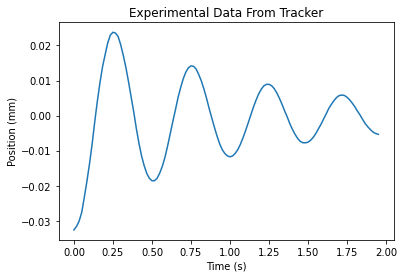

In [3]:
#Run SciPy Opitmization regession fit 
run_fit = False

#import test data and convert to numPy arrays
data = pd.read_excel(r'damping data_cut.xlsx')
df = data.to_numpy()
length = df.shape[0]

fig = plt.figure()
plt.plot(df[:,1],df[:,3])
plt.title('Experimental Data From Tracker')
plt.xlabel('Time (s)')
plt.ylabel('Position (mm)')

# Constants of Model

Adding dimensions and interias of segment based off of physical laminate structure. Link dimensions were 50mm x 30 mm x 1 mm. Mass of the tracker was 0.0588 grams and mass of the segment was 1 gram. These values were gotten from teammates from their parameterization documents.

In [4]:
#Parameterization
 
#Defining Constants of System
seg_len = 0.050    #segment mass
seg_mass = 0.001 #segment mass 
seg_h = 0.040 #segment height
seg_th = 0.001

#Set segment lengths
lA = Constant(seg_len,'lA',system)
lB = Constant(seg_len,'lB',system)

#Set masses
mA = Constant(seg_mass,'mA',system)
mB = Constant(seg_mass,'mB',system)
mM = Constant(.001/17,'mM',system) #17 trackers was 1 gram so divided to find mass of tracker

g = Constant(9.81,'g',system)
b = Constant(2.14176688e-06,'b',system) #values generated fro sciPy.minimize
k = Constant(1.59953557e-04,'k',system) #values generated fro sciPy.minimize
area = Constant(seg_len*seg_h,'area',system)
rho = Constant(1.059,'rho',system)

Ixx = Constant((1/12*seg_mass*(seg_h**2 + seg_th**2)),'Ixx',system)
Iyy = Constant((1/12*seg_mass*(seg_h**2 + seg_len**2)),'Iyy',system)
Izz = Constant((1/12*seg_mass*(seg_len**2 + seg_th**2)),'Izz',system)

#Define derivatives of frames
qA,qA_d,qA_dd = Differentiable('qA',system)

#set initial conditions
initialvalues = {}
initialvalues[qA]=-41*pi/180 #Initial state of experiment
initialvalues[qA_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

#Set simulation run time
tinitial = 0
tfinal = df[length-1,1]  #time of simulation to match time of experiment
fps = length/tfinal
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

# Kinematics of Model

Adding kinematics of syste. Adding the body of the link and a particle mass of the tracker to the end of the segment.

In [5]:
#Kinematics

#Frames
N = Frame('N',system)
A = Frame('A',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)

#Vectors
pNA=0*N.x
pAB=pNA+lA*A.x

#Centers of Mass
pAcm=pNA+lA/2*A.x
pMcm=pNA+lA*A.x

#Angular Velocity
wNA = N.get_w_to(A) 

#Velocity of Center of Mass
vA=pAcm.time_derivative()

#Interia and Bodys
IA = Dyadic.build(A,Ixx,Iyy,Izz)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyM = Particle(pMcm,mM,'ParticleM',system) #Mass of blue dot tracker

# Adding Force

Forces were added to the model. Gravity, Aerodynamic against flat plate, spring force and damping force.

In [6]:
#Forces

#Gravity
system.addforcegravity(-g*N.z)

#Aerodynamic Forces
f_aero_A = rho * vA.length()*(vA.dot(A.y))*area*A.y
system.addforce(-f_aero_A,vA)

#Spring Forces
system.add_spring_force1(k, (qA)*N.z, wNA)

#Damping Force
system.addforce(-b*wNA, wNA)

# Building Model

Solve for the equations of motion and run the opitimization algorithm if run_fit was set to true

In [7]:
#Constraints and Plots

f,ma = system.getdynamics();


tol = 1e-12
points = [pNA,pAB]

def run_sim(args):
    constants = dict([(key,value) for key,value in zip(unknown_constants,args)])
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':constants},))
    return states

def calc_error(args):
    states_guess = run_sim(args)
    points_output = PointsOutput(points,system)
    y_guess =  points_output.calc(states_guess,t)
    error = df[:,3] - y_guess[:,1,1]
    error **=2
    error = error.sum()
    return error

pynamics.system.logger.setLevel(logging.ERROR)

if run_fit:
    
    unknown_constants = [b,k]

    known_constants = list(set(system.constant_values.keys())-set(unknown_constants))
    known_constants = dict([(key,system.constant_values[key]) for key in known_constants])

    func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True,constants = known_constants)

    guess = [3e-6,2.17e-4]

    pynamics.system.logger.setLevel(logging.ERROR)
    
    sol = scipy.optimize.minimize(calc_error,guess)
    print(sol.fun)
    result = sol.x

    error_f = calc_error(result)

2022-04-12 21:12:24,585 - pynamics.system - INFO - getting dynamic equations


# Plots of Results

Plotting the results of the simulated tip of the simulation against the experimental tip.

2022-04-12 21:20:01,370 - pynamics.integration - INFO - beginning integration
2022-04-12 21:20:01,550 - pynamics.integration - INFO - finished integration
2022-04-12 21:20:01,559 - pynamics.output - INFO - calculating outputs
2022-04-12 21:20:01,561 - pynamics.output - INFO - done calculating outputs


Dapming and Spring Constants Respectivly: [2.14176688e-06 1.59953557e-04]
Squared Error from SciPy.Optimize: 0.0002384852610771121


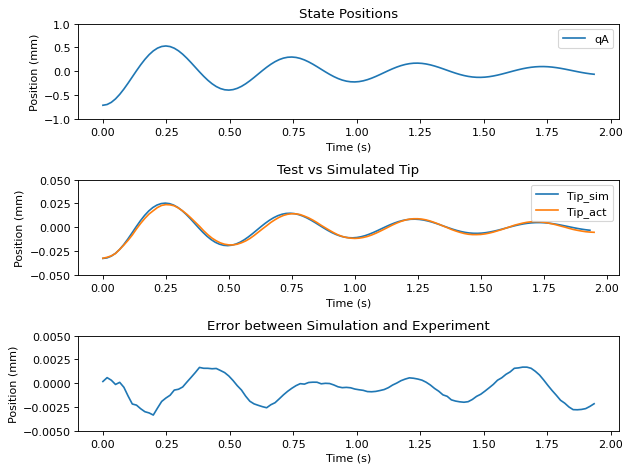

In [16]:
if run_fit:
    states2 = run_sim(result)
    points_output2 = PointsOutput(points,system)
    y2 = points_output2.calc(states2,t)

    fig = plt.figure()
    ax1 = plt.subplot(2,1,2)
    ax1.plot(t,states2[:,:1])
    ax1.legend(['qA'])
    ax1.set_title('State Positions')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (mm)')

    ax2 = plt.subplot(2,1,1)
    ax2.plot(t,y2[:,1,1],df[:,1],df[:,3])
    ax2.legend(['pBtip_s' ,'pBtip_a'])
    ax2.set_title('Test vs CMA Tip')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Position (mm)')

    fig.tight_layout()

    print(result)
    print(error_f)
    
else:
    
    func1 = system.state_space_post_invert(f,ma,return_lambda = False)
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':system.constant_values},))

    points_output = PointsOutput(points,system) 
    y = points_output.calc(states,t)

    fig = plt.figure(figsize=(8, 6), dpi=80)

    ax1 = plt.subplot(3,1,1)
    ax1.plot(t,states[:,:1])
    ax1.legend(['qA'])
    ax1.set_title('State Positions')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (mm)')
    ax1.set_ylim([-1, 1])

    ax2 = plt.subplot(3,1,2)
    ax2.plot(t,y[:,1,1],df[:,1],df[:,3])
    ax2.legend(['Tip_sim' ,'Tip_act'])
    ax2.set_title('Test vs Simulated Tip')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Position (mm)')
    ax2.set_ylim([-.05, 0.05])
    
    ax3 = plt.subplot(3,1,3)
    ax3.plot(t,(df[:,3]-y[:,1,1]))
    ax3.set_title('Error between Simulation and Experiment')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Position (mm)')
    ax3.set_ylim([-.005, .005])
    
    fig.tight_layout()
    
    print('Dapming and Spring Constants Respectivly: [2.14176688e-06 1.59953557e-04]')
    print('Squared Error from SciPy.Optimize: 0.0002384852610771121')